## Loading Image and Label

In [1]:
import nibabel as nib
import matplotlib.pyplot as plt

In [2]:
image = nib.load('/cluster/projects/vc/data/mic/open/Prostate/PI-CAI/preped-images/images/imagesTr/10005_1000005.nii.gz').get_fdata()
label = nib.load('/cluster/projects/vc/data/mic/open/Prostate/PI-CAI/preped-images/images/labelsTr/10005_1000005.nii.gz').get_fdata()

In [3]:
print(image.shape)
print(label.shape)

(384, 384, 19, 3)
(384, 384, 19)


In [4]:
import numpy as np

print("Min value:", np.min(image))
print("Max value:", np.max(image))
print("Mean value:", np.mean(image))
print("Unique values:", np.unique(image))


Min value: 0.0
Max value: 3476.0
Mean value: 243.2140934815881
Unique values: [0.000e+00 1.000e+00 2.000e+00 ... 3.452e+03 3.472e+03 3.476e+03]


## Visualizing Slice and True Segmentation

In [5]:
slice = 8
img_data = image[:, :, slice]
label_data = label[:, :, slice]

img_data = (img_data - np.min(img_data)) / (np.max(img_data) - np.min(img_data))

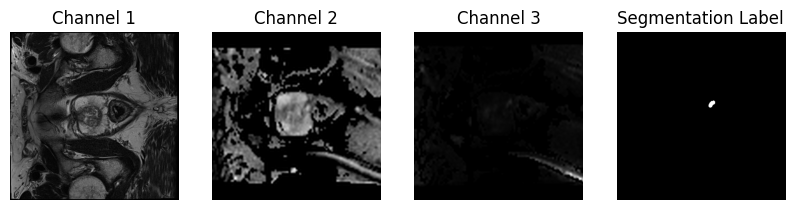

In [6]:
fig, axes = plt.subplots(1, 4, figsize=(10, 5))

axes[0].imshow(img_data[:, :, 0], cmap="gray")
axes[0].set_title("Channel 1")
axes[0].axis("off")

axes[1].imshow(img_data[:, :, 1], cmap="gray")  
axes[1].set_title("Channel 2")
axes[1].axis("off")

axes[2].imshow(img_data[:, :, 2], cmap="gray")  
axes[2].set_title("Channel 3")
axes[2].axis("off")

axes[3].imshow(label_data, cmap="gray")  
axes[3].set_title("Segmentation Label")
axes[3].axis("off")
plt.show()

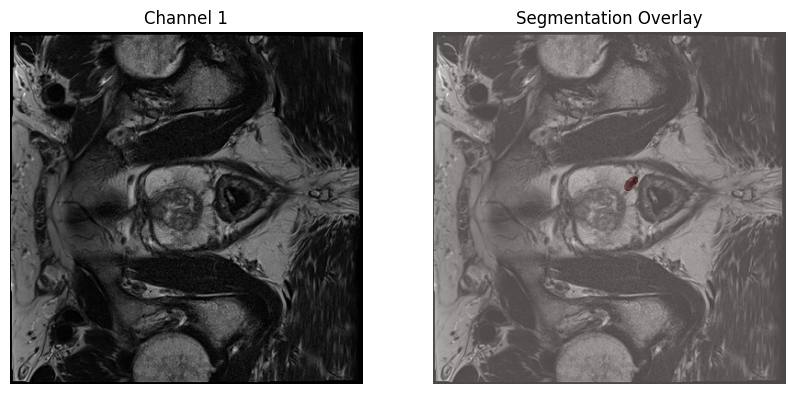

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img_data[:, :, 0], cmap="gray")
axes[0].set_title("Channel 1")
axes[0].axis("off")

axes[1].imshow(img_data[:, :, 0], cmap="gray")  
axes[1].imshow(label_data, cmap="Reds", alpha=0.3)  
axes[1].set_title("Segmentation Overlay")
axes[1].axis("off")
plt.show()

## Loading the Dataset

In [8]:
from monai.transforms import (
    EnsureChannelFirstd,
    LoadImage,
    LoadImaged,
    Orientationd,
    Rand3DElasticd,
    RandAffined,
    Spacingd,
)
from monai.config import print_config
from monai.apps import download_and_extract
import tempfile
import shutil
import os
import glob

print_config()

MONAI version: 1.3.2
Numpy version: 1.26.4
Pytorch version: 2.4.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 59a7211070538586369afd4a01eca0a7fe2e742e
MONAI __file__: /cluster/home/<username>/mamba-mic/.venv/lib64/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 11.0.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.19.1+cu121
tqdm version: 4.66.5
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.8
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.8.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd 

In [9]:
train_images = sorted(glob.glob(os.path.join('/cluster/projects/vc/data/mic/open/Prostate/PI-CAI/preped-images/images/imagesTr', "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join('/cluster/projects/vc/data/mic/open/Prostate/PI-CAI/preped-images/images/labelsTr', "*.nii.gz")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_data_dicts, val_data_dicts = data_dicts[:-9], data_dicts[-9:]

In [10]:
train_data_dicts[0]

{'image': '/cluster/projects/vc/data/mic/open/Prostate/PI-CAI/preped-images/images/imagesTr/10005_1000005.nii.gz',
 'label': '/cluster/projects/vc/data/mic/open/Prostate/PI-CAI/preped-images/images/labelsTr/10005_1000005.nii.gz'}

## Applying Pre-Processing

In [11]:
loader = LoadImage(dtype=np.float32, image_only=True)

In [12]:
image = loader(train_data_dicts[0]["image"])
# print(f"input: {train_data_dicts[0]['image']}")
print(f"image shape: {image.shape}")
print(f"image affine:\n{image.meta['affine']}")
print(f"image pixdim:\n{image.pixdim}")

image shape: torch.Size([384, 384, 19, 3])
image affine:
tensor([[-5.0000e-01, -1.0255e-10, -7.2325e-17,  1.1510e+02],
        [ 1.0170e-10, -4.9584e-01, -3.8639e-01,  7.6833e+01],
        [ 1.3208e-11, -6.4398e-02,  2.9750e+00,  1.1523e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],
       dtype=torch.float64)
image pixdim:
tensor([0.5000, 0.5000, 3.0000], dtype=torch.float64)


In [13]:
loader = LoadImaged(keys=("image", "label"), image_only=False)

In [14]:
data_dict = loader(train_data_dicts[0])
# print(f"input:, {train_data_dicts[0]}")
print(f"image shape: {data_dict['image'].shape}")
print(f"label shape: {data_dict['label'].shape}")
print(f"image pixdim:\n{data_dict['image'].pixdim}")

image shape: torch.Size([384, 384, 19, 3])
label shape: torch.Size([384, 384, 19])
image pixdim:
tensor([0.5000, 0.5000, 3.0000], dtype=torch.float64)


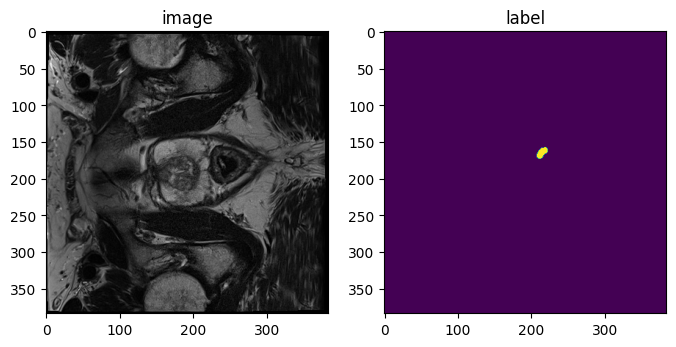

In [15]:
image, label = data_dict["image"], data_dict["label"]
plt.figure("visualize", (8, 4))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, slice, 0], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, slice])
plt.show()

### Move channels to first

In [16]:
ensure_channel_first = EnsureChannelFirstd(keys=["image", "label"])
datac_dict = ensure_channel_first(data_dict)
print(f"image shape: {datac_dict['image'].shape}")

image shape: torch.Size([3, 384, 384, 19])


### Reorientation

In [17]:
orientation = Orientationd(keys=["image", "label"], axcodes="PLI")

In [18]:
data_dict = orientation(datac_dict)
print(f"image shape: {data_dict['image'].shape}")
print(f"label shape: {data_dict['label'].shape}")
print(f"image affine after Spacing:\n{data_dict['image'].meta['affine']}")
print(f"label affine after Spacing:\n{data_dict['label'].meta['affine']}")

image shape: torch.Size([3, 384, 384, 19])
label shape: torch.Size([1, 384, 384, 19])
image affine after Spacing:
tensor([[-1.0255e-10, -5.0000e-01,  7.2325e-17,  1.1510e+02],
        [-4.9584e-01,  1.0170e-10,  3.8639e-01,  6.9878e+01],
        [-6.4398e-02,  1.3208e-11, -2.9750e+00,  5.4703e+01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],
       dtype=torch.float64)
label affine after Spacing:
tensor([[-4.2707e-13, -5.0000e-01, -3.9625e-11,  1.1510e+02],
        [-4.9584e-01, -4.2707e-13,  3.8639e-01,  6.9878e+01],
        [-6.4398e-02,  6.6041e-12, -2.9750e+00,  5.4703e+01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],
       dtype=torch.float64)


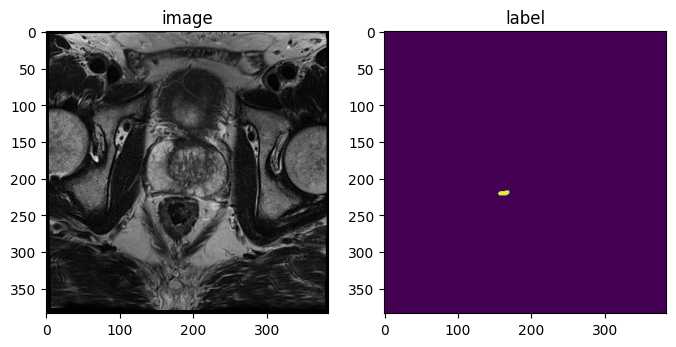

In [19]:
image, label = data_dict["image"], data_dict["label"]
plt.figure("visualise", (8, 4))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[0, :, :, slice], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice])
plt.show()

### Resample to set voxel size

In [20]:
spacing = Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 5.0), mode=("bilinear", "nearest"))

In [21]:
data_dict = spacing(data_dict)
print(f"image shape: {data_dict['image'].shape}")
print(f"label shape: {data_dict['label'].shape}")
print(f"image affine after Spacing:\n{data_dict['image'].meta['affine']}")
print(f"label affine after Spacing:\n{data_dict['label'].meta['affine']}")

image shape: torch.Size([3, 129, 129, 12])
label shape: torch.Size([1, 129, 129, 12])
image affine after Spacing:
tensor([[-3.0766e-10, -1.5000e+00,  1.1091e-16,  1.1510e+02],
        [-1.4875e+00,  3.0509e-10,  6.4398e-01,  6.9878e+01],
        [-1.9319e-01,  3.9625e-11, -4.9584e+00,  5.4703e+01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],
       dtype=torch.float64)
label affine after Spacing:
tensor([[-1.2812e-12, -1.5000e+00, -6.6041e-11,  1.1510e+02],
        [-1.4875e+00, -1.2812e-12,  6.4398e-01,  6.9878e+01],
        [-1.9319e-01,  1.9812e-11, -4.9584e+00,  5.4703e+01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],
       dtype=torch.float64)


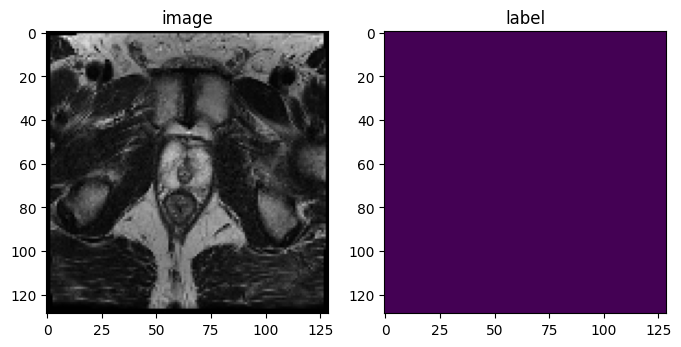

In [22]:
image, label = data_dict["image"], data_dict["label"]
plt.figure("visualise", (8, 4))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[0, :, :, slice], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice])
plt.show()

### Random affine transformation

In [23]:
rand_affine = RandAffined(
    keys=["image", "label"],
    mode=("bilinear", "nearest"),
    prob=1.0,
    spatial_size=(100, 100, 12),
    translate_range=(40, 40, 2),
    rotate_range=(np.pi / 36, np.pi / 36, np.pi / 4),
    scale_range=(0.15, 0.15, 0.15),
    padding_mode="border",
)
rand_affine.set_random_state(seed=123)

image shape: torch.Size([3, 100, 100, 12])


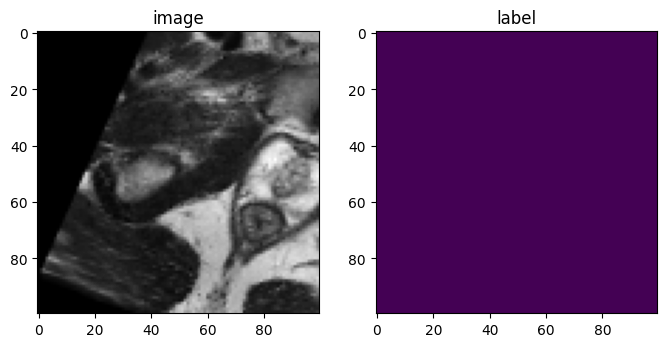

In [24]:
affined_data_dict = rand_affine(data_dict)
print(f"image shape: {affined_data_dict['image'].shape}")

image, label = affined_data_dict["image"][0], affined_data_dict["label"][0]
plt.figure("visualise", (8, 4))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, slice], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, slice])
plt.show()

### Random Elastic Deformation

In [25]:
rand_elastic = Rand3DElasticd(
    keys=["image", "label"],
    mode=("bilinear", "nearest"),
    prob=1.0,
    sigma_range=(5, 8),
    magnitude_range=(100, 200),
    spatial_size=(100, 100, 10),
    translate_range=(50, 50, 2),
    rotate_range=(np.pi / 36, np.pi / 36, np.pi),
    scale_range=(0.15, 0.15, 0.15),
    padding_mode="border",
)
rand_elastic.set_random_state(seed=123)

image shape: torch.Size([3, 100, 100, 10])


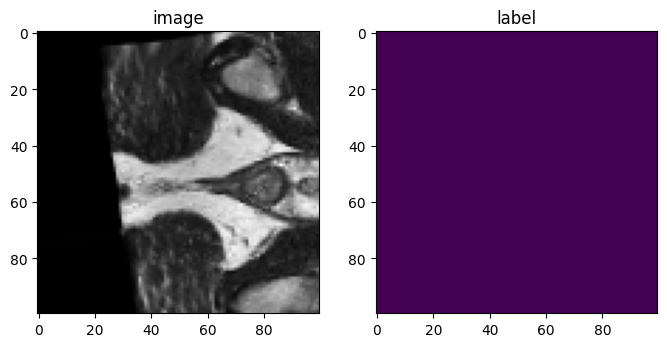

In [26]:
deformed_data_dict = rand_elastic(data_dict)
print(f"image shape: {deformed_data_dict['image'].shape}")

image, label = deformed_data_dict["image"][0], deformed_data_dict["label"][0]
plt.figure("visualise", (8, 4))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, slice], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, slice])
plt.show()